In [35]:
!pip install -q pycaret optuna

##Importing necessary libraries

In [86]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler
from pycaret.regression import setup, compare_models

from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

from optuna import create_study

##Load + partition

In [37]:
!unzip '/content/playground-series-s3e26.zip' data

Archive:  /content/playground-series-s3e26.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [38]:
train_set = pd.read_csv("/content/train.csv")
test_set = pd.read_csv("/content/test.csv")
sample_sub = pd.read_csv("/content/sample_submission.csv")

In [39]:
train0 = train_set.copy()
test0 = test_set.copy()

In [40]:
test_ids = test0.id
test0.drop("id", axis=1, inplace=True)

target = train0["Status"]

train0.drop(["id", "Status"], axis=1, inplace=True)

data = pd.concat([train0, test0], axis=0)

In [41]:
target_map = {
    'C': 0,
    'CL': 1,
    'D': 2
}

##EDA

In [42]:
data.select_dtypes("object").columns

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [43]:
categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

numerical_columns = [col for col in data.columns if col not in categorical_columns]

In [44]:
skew_df = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data[feature]))
skew_df['Absolute skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute skew'].apply(lambda x: True if x >= 0.5 else False                                                                              )
skew_df

,Feature,Skew,Absolute skew,Skewed
0,N_Days,0.441024,0.441024,False
1,Age,0.043244,0.043244,False
2,Bilirubin,3.373655,3.373655,True
3,Cholesterol,3.675326,3.675326,True
4,Albumin,-0.569451,0.569451,True
5,Copper,2.768250,2.768250,True
6,Alk_Phos,3.204595,3.204595,True
7,SGOT,1.588936,1.588936,True
8,Tryglicerides,2.557610,2.557610,True
9,Platelets,0.422047,0.422047,False


In [45]:
for col in categorical_columns:
  encoder = LabelEncoder()
  encoder.fit(data[col])
  data[col] = encoder.transform(data[col])

for col in numerical_columns:
  encoder = MinMaxScaler()
  encoder.fit(np.array(data[col]).reshape(-1, 1))
  data[col] = encoder.transform(np.array(data[col]).reshape(-1, 1))

data.columns = data.columns.astype(str)

##Unskewing

In [46]:
for col in skew_df.query("Skewed == True")["Feature"].values:
  data[col] = np.log1p(data[col])

In [47]:
data1 = data.copy()

##OneHot Encoding

In [48]:
data1 = pd.get_dummies(data1)

In [49]:
target = target.map(target_map)

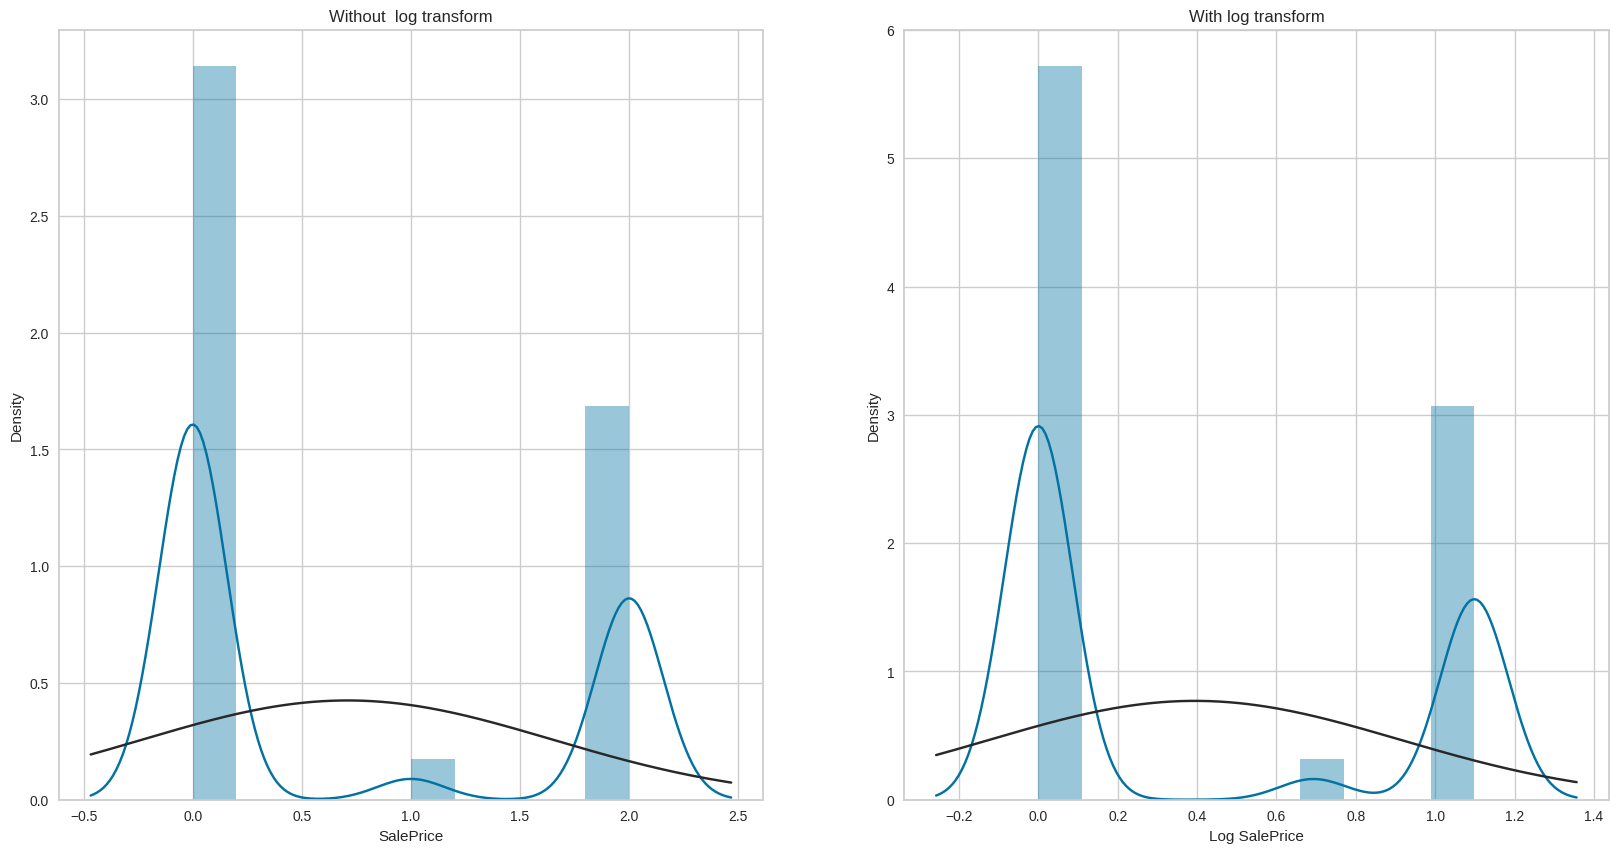

In [50]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without  log transform")
plt.xlabel("SalePrice")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target+1), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With log transform")

plt.show()

##Training

In [51]:
train_final = data1.loc[:train0.index.max(), :].copy()
test_final = data1.loc[train0.index.max():, :].reset_index(drop=True).copy()

In [52]:
_ = setup(data=pd.concat([train_final, target], axis=1), target='Status')

,Description,Value
0,Session id,5908
1,Target,Status
2,Target type,Regression
3,Original data shape,"(7905, 19)"
4,Transformed data shape,"(7905, 19)"
5,Transformed train set shape,"(5533, 19)"
6,Transformed test set shape,"(2372, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [53]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4395,0.4267,0.6528,0.5140,0.3702,0.3272,0.5390
gbr,Gradient Boosting Regressor,0.4624,0.4277,0.6536,0.5128,0.3714,0.3426,0.8580
rf,Random Forest Regressor,0.4585,0.4440,0.6660,0.4943,0.3792,0.3346,3.5740
et,Extra Trees Regressor,0.4676,0.4453,0.6669,0.4929,0.3810,0.3398,1.1290
xgboost,Extreme Gradient Boosting,0.4756,0.4792,0.6918,0.4541,0.3917,0.3413,0.4300
ada,AdaBoost Regressor,0.5782,0.4988,0.7060,0.4320,0.4123,0.3801,0.1070
ridge,Ridge Regression,0.5605,0.5125,0.7156,0.4159,0.4049,0.4057,0.0980
br,Bayesian Ridge,0.5604,0.5125,0.7156,0.4159,0.4048,0.4056,0.0480
lar,Least Angle Regression,0.5597,0.5126,0.7156,0.4158,0.4047,0.4052,0.0750
lr,Linear Regression,0.5597,0.5126,0.7156,0.4158,0.4047,0.4052,0.9260


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

LGBMRegressor(n_jobs=-1, random_state=5908)

In [87]:
'''
preds = []
for model in models:
  model.fit(train_final, target)
  pred = model.predict_proba(test_final)
  preds.append(pred)


#pred_final = 0.8*preds[0] + 0.1*preds[1] + 0.1*preds[2]
'''

estimators = [
    ('lgbm', LGBMClassifier(n_jobs=-1, random_state=1064)),
    ('gbr', GradientBoostingClassifier()),
    ('rf', RandomForestClassifier(n_jobs=-1))
]

clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',
    cv=5
)

In [88]:
clf.fit(train_final, target)
pred_final = clf.predict_proba(test_final)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1921
[LightGBM] [Info] Number of data points in the train set: 7905, number of used features: 18
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 18
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start tr

In [70]:
def objective(trial):
    # Define hyperparameters to optimize for GradientBoostingClassifier
    gbr_params = {
        'n_estimators': trial.suggest_int('gbr_n_estimators', 10, 100),
        'learning_rate': trial.suggest_float('gbr_learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('gbr_max_depth', 2, 32, log=True),
    }

    # Define hyperparameters to optimize for LGBMClassifier
    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 10, 100),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 2, 64),
    }

    # Define hyperparameters to optimize for MLPClassifier
    mlp_params = {
        'hidden_layer_sizes': trial.suggest_tuple('mlp_hidden_layer_sizes', (50, 50), (100, 100)),
        'alpha': trial.suggest_float('mlp_alpha', 1e-5, 1e-1, log=True),
    }

    # Create base classifiers with the suggested hyperparameters
    gbr_clf = GradientBoostingClassifier(**gbr_params)
    lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=1064, **lgbm_params)
    mlp_clf = MLPClassifier(**mlp_params)

    # Create stacking classifier with base and meta classifiers
    estimators = [('gbr', gbr_clf), ('lgbm', lgbm_clf), ('mlp', mlp_clf)]
    final_estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)  # Fixed values for simplicity
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator, stack_method='predict_proba')

    # Train the stacking classifier
    stack_clf.fit(train_final, target)

    # Evaluate log loss on the test set
    y_proba = stack_clf.predict_proba(train_final)
    loss = log_loss(target, y_proba)

    return loss

In [71]:
study = create_study()
study.optimize(objective, n_trials=50)

[I 2023-12-22 18:54:43,114] A new study created in memory with name: no-name-5d239168-5af5-4065-9ea7-aba41c93b4e0
[W 2023-12-22 18:54:43,119] Trial 0 failed with parameters: {'gbr_n_estimators': 65, 'gbr_learning_rate': 0.05139473611593162, 'gbr_max_depth': 13, 'lgbm_n_estimators': 11, 'lgbm_learning_rate': 0.059079592499382216, 'lgbm_num_leaves': 58} because of the following error: AttributeError("'Trial' object has no attribute 'suggest_tuple'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-70-b0c8b766bbde>", line 18, in objective
    'hidden_layer_sizes': trial.suggest_tuple('mlp_hidden_layer_sizes', (50, 50), (100, 100)),
AttributeError: 'Trial' object has no attribute 'suggest_tuple'
[W 2023-12-22 18:54:43,125] Trial 0 failed with value None.


AttributeError: ignored

##Delete Headers

In [89]:
pred_final = [pred_final[1:,i] for i in range(3)]

##Fusion

In [90]:
pred_final = pd.DataFrame(
    {
        'id': test_ids,
        'Status_C': pred_final[0],
        'Status_CL': pred_final[1],
        'Status_D': pred_final[2]
    }
)


In [ ]:
pred_final.head

In [91]:
pred_final.to_csv("submission.csv", index=False, header=True)